In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import spearmanr

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from nudging.parallel import execute_parallel
from nudging.correlation import smooth_data
from nudging.model import BiRegressor, MonoRegressor, XRegressor
from nudging.cate import get_cate_correlations, get_cate_top_performance
from nudging.simulation import generate_datasets

### Create the datasets

This creates 1000 datasets, where each of them have different parameters for generation. They include both linear and non-linear datasets.

In [2]:
np.random.seed(12390845)
datasets = generate_datasets(1000)

### Define the regressors and meta-learners to test

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, SGDRegressor, ElasticNet
from sklearn.linear_model import ARDRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
regressors = {
    "gauss_process": GaussianProcessRegressor,
    "ridge": Ridge,
    "linear": LinearRegression,
    "sgd": SGDRegressor,
    "elasticnet": ElasticNet,
    "ard": ARDRegression,
    "bayesian_ridge": BayesianRidge,
    "knn": KNeighborsRegressor,
    "mlp": MLPRegressor,
    "svm": SVR,
    "decision_tree": DecisionTreeRegressor,
    "extra_tree": ExtraTreeRegressor,
}


learner_dict = {
    "s-learner": MonoRegressor,
    "t-learner": BiRegressor,
    "x-learner": XRegressor,
}

### Define the function to compute the performance results from a single dataset/learner/regressor

In [4]:
@ignore_warnings(category=ConvergenceWarning)
def compute_learners(i_data, model_name, learner_type):
    regressor = regressors[model_name]
    data = datasets[i_data]
    model = learner_dict[learner_type](regressor())
    top_perf, spear_perf = get_cate_top_performance(model, data, spearmanr_results=True)
    return {
        "model_name": model_name,
        "learner_type": learner_type,
        "top": top_perf,
        "spearmanr": spear_perf,
    }

### Create jobs for each dataset/learner/regressor combination (36K)

In [5]:
jobs = []
for name in regressors:
    for learner_type in learner_dict:
        jobs.extend([{"i_data": i_data, "model_name": name, "learner_type": learner_type}
                     for i_data in range(len(datasets))])

### Execute the jobs in parallel

The number of parallel jobs can be set with n_jobs, but this doesn't have to be equal to the number of (virtual) cores in the system, since many of the regressors are already run in parallel themselves.

In [6]:
results = execute_parallel(jobs, compute_learners, progress_bar=True, n_jobs=10)

100%|████████████████████████████████████████████| 36000/36000 [1:37:28<00:00,  6.16it/s]


### Aggregate the results from the jobs so that it becomes easier to manipulate

In [7]:
def aggregate_results(results):
    if isinstance(results, dict):
        return results
    agg_results = {}
    for model_name in regressors:
        agg_results[model_name] = {}
        for learner_type in learner_dict:
            top_results = [x["top"] for x in results 
                           if x["model_name"] == model_name and x["learner_type"] == learner_type]
            spear_results = [x["spearmanr"] for x in results 
                             if x["model_name"] == model_name and x["learner_type"] == learner_type]
            agg_results[model_name][learner_type] = {"top": top_results, "spear": spear_results}
    return agg_results

In [8]:
results = aggregate_results(results)

### The plot function below creates scatter plots from the data

It does so for one particular meta-learner or regressor. It is basically the cumulative distribution function for the spearmanr/top correlation.

In [9]:
def plot_results(name, results, use_spear=False):
    plt.figure(dpi=150)
    if use_spear:
        res_key = "spear"
    else:
        res_key = "top"
    plt.title(f"{name}: {res_key}")
    all_data = {}
    if name in learner_dict:
        for model_name in regressors:
            all_data[model_name] = results[model_name][name][res_key]
    else:
        for learner_type in learner_dict:
            all_data[learner_type] = results[name][learner_type][res_key]
            
    sorted_items = sorted(all_data.items(), key=lambda x: np.mean(x[1]), reverse=True)
    for other_name, data in sorted_items:
        plt.scatter(np.arange(len(data)), np.sort(data), label=f"{other_name}: {np.mean(data): .3f}")
    plt.legend(bbox_to_anchor=(1.04,1))
    plt.show()

We already know that the t-learner and x-learner are very similar in performance. The s-learner (single regressor) is way worse for almost all of the models. The top 3 regressors are `ard`, `linear` and `ridge`, which have almost the same performance. `bayesian_ridge` is a good 4th.

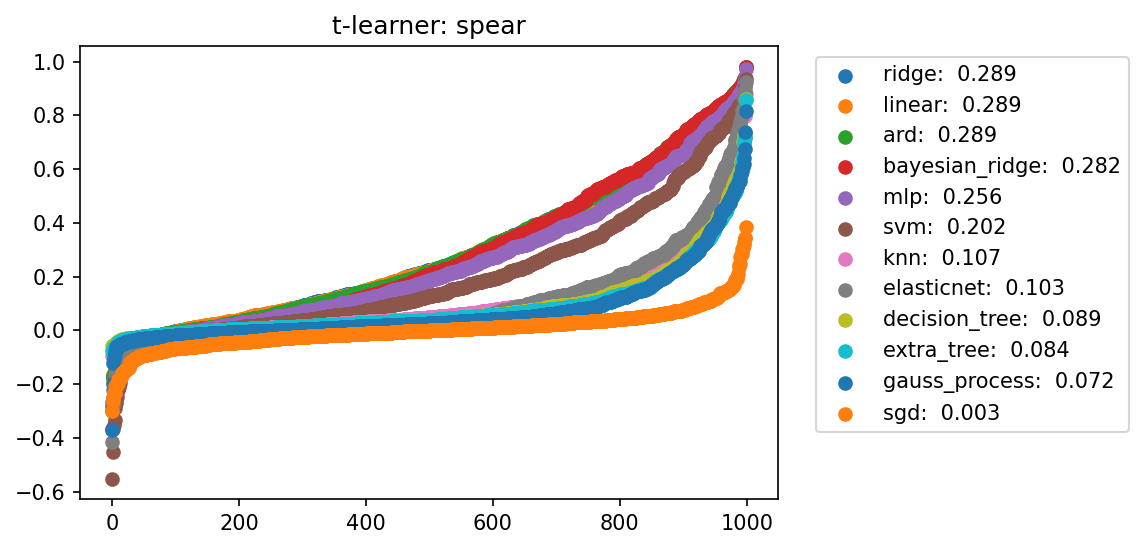

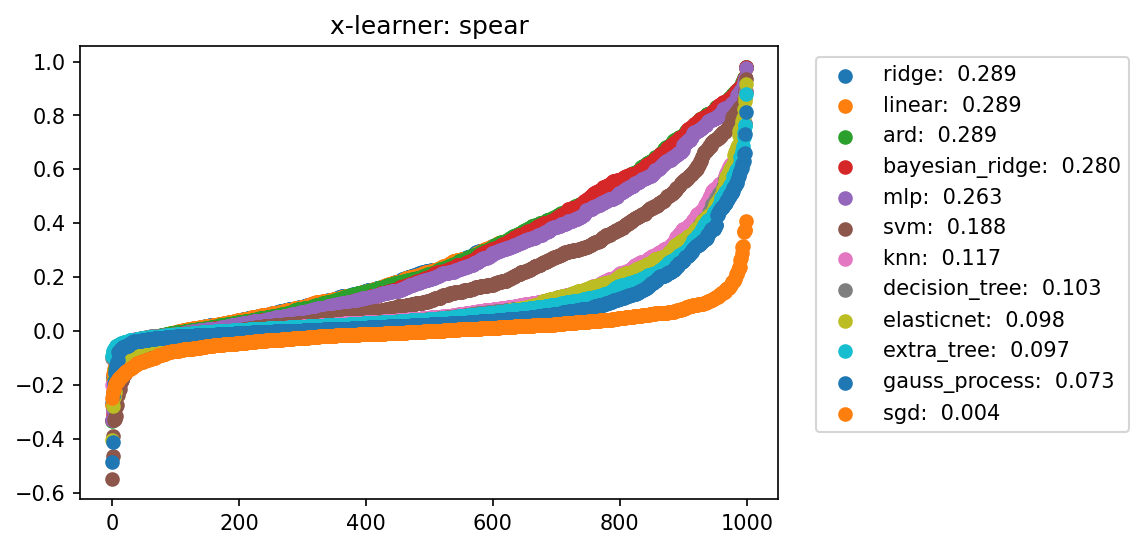

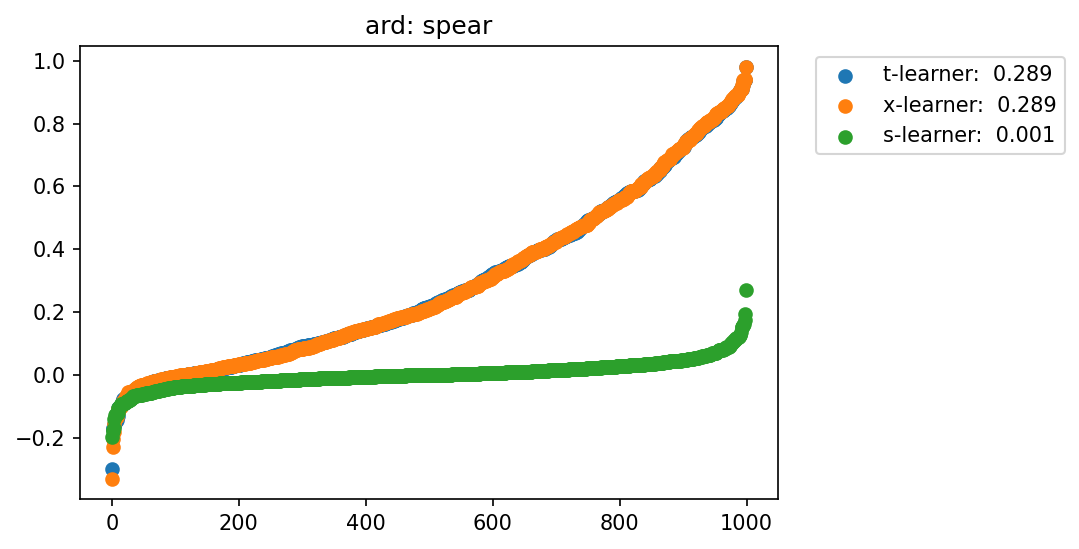

In [10]:
plot_results("t-learner", results, use_spear=True)
plot_results("x-learner", results, use_spear=True)
plot_results("ard", results, use_spear=True)

The function below can plot the dependencies of the correlations as a function of the parameters used for the dataset. This is useful, since we can then more easily understand in which situations models perform better/worse compared to each other.

In [11]:
def plot_dependencies(attr, name, n_data=50, use_spear=True):
    plt.figure(dpi=150)
    if use_spear:
        res_key = "spear"
    else:
        res_key = "top"
    plt.title(f"{name}: {res_key}")
    all_data = {}
    if name in learner_dict:
        for model_name in regressors:
            all_data[model_name] = results[model_name][name][res_key]
    else:
        for learner_type in learner_dict:
            all_data[learner_type] = results[name][learner_type][res_key]
            
    sorted_items = sorted(all_data.items(), key=lambda x: np.mean(x[1]), reverse=True)
    x = np.array([d.truth[attr] for d in datasets])
    for other_name, data in sorted_items:
        xy_corr = spearmanr(x, data).correlation
        x_smooth, y_smooth = smooth_data(x, data, n_data=n_data)
        plt.plot(x_smooth, y_smooth, label=f"{other_name}: {xy_corr: .3f}")
    plt.legend(bbox_to_anchor=(1.04,1))
    plt.show()

The plot below shows the parameter `noise_frac`, which tells us how much noise is added to the system. As expected, more noise means worse results for the determination of the cate.The top performers have very similar behavior in this regard.

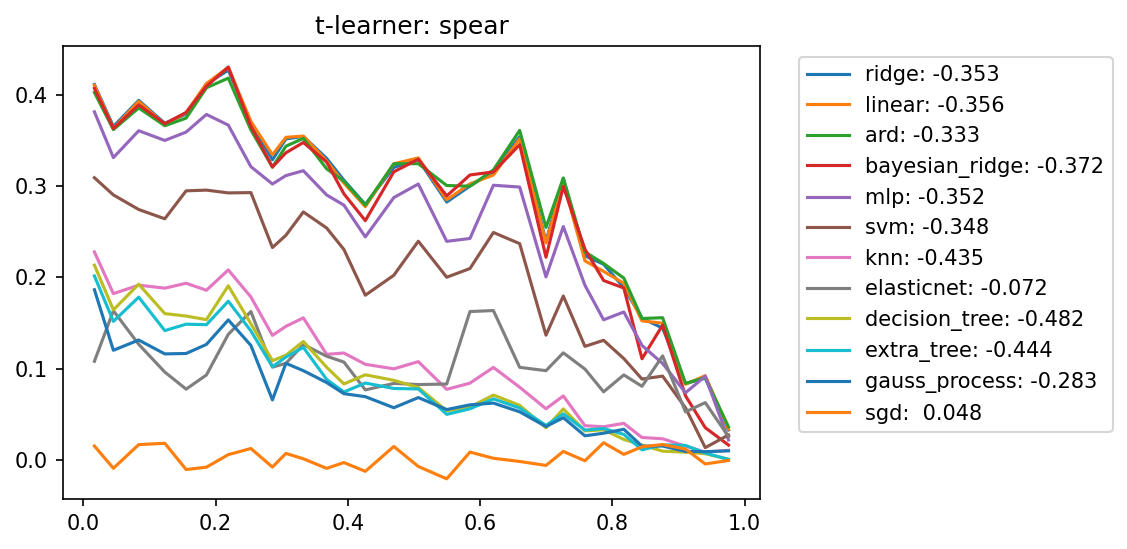

In [12]:
plot_dependencies("noise_frac", "t-learner", n_data=30)

We do the same for the number of samples. As expected, the higher the number of samples, the better the inference of the CATE. Interestingly the neural network `mlp` has a stronger correlation to the number of samples than the other good regressors, which reinforces the notion that indeed neural networks are very data hungry.

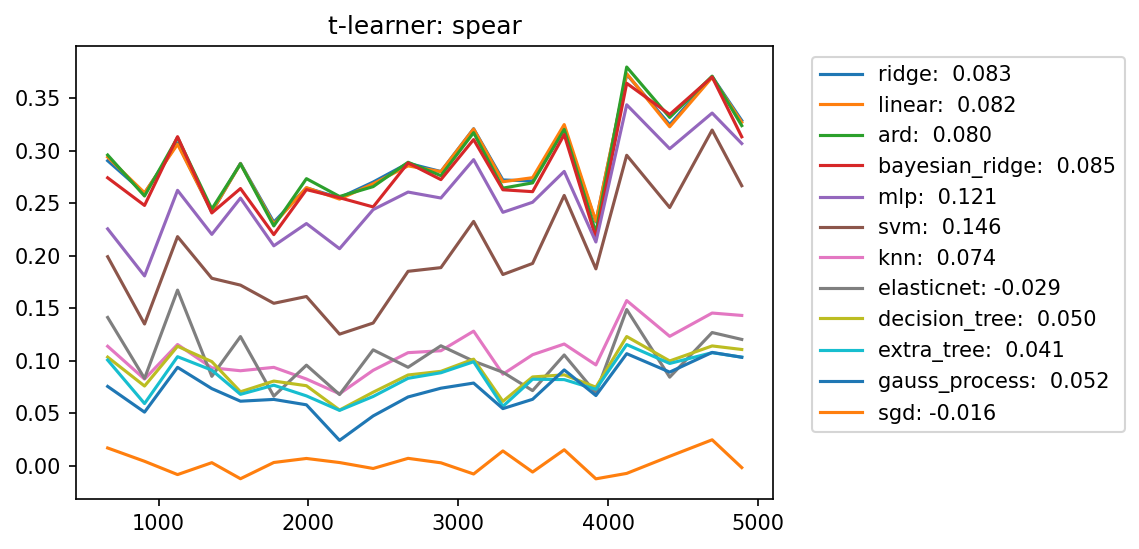

In [13]:
plot_dependencies("n_samples", "t-learner", n_data=20)